In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/data'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.5 GB  | Proc size: 746.5 MB
GPU RAM Free: 11320MB | Used: 121MB | Util   1% | Total 11441MB


In [0]:
!ls "/content/gdrive/My Drive/data"

original  resized_224  resized_299


In [0]:
import cv2
import tensorflow
import keras
from keras import layers
from keras import models
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image 
from keras.models import Model
from keras import backend as K 
from keras.preprocessing import image
from keras.layers import Activation, Dense
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import ZeroPadding2D
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras import optimizers 
from keras.preprocessing.image import ImageDataGenerator 
import os 
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#directory of the dataset
base_dir = '/content/gdrive/My Drive/data/resized_299'

train_dir = '/content/gdrive/My Drive/data/resized_299/train'
validation_dir = '/content/gdrive/My Drive/data/resized_299/validation'
test_dir = '/content/gdrive/My Drive/data/resized_299/test'



In [0]:
#create the base pre_trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

#adding a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

#adding fully connected layer
x = Dense(1024, activation='relu')(x)

#adding a logistic output layer
predictions = Dense(1, activation = 'sigmoid')(x)

#to train 
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

#train only top layers
#freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
  layer.trainable = False 
  

#compile the model 
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(5e-6),
              metrics=['acc'])

#choose to train top 2 inception blocks, i.e to freeze 

# call each layers to observe which to freeze or upfreeze
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True
  
#compile the model 
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(),
              metrics=['acc'])

#add data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

print(train_dir)
print(validation_dir)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299,299),
    batch_size=64,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(299,299),
    batch_size=64,
    class_mode='binary')


history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=10,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=50)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_471 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_471 (BatchN (None, None, None, 3 96          conv2d_471[0][0]                 
__________________________________________________________________________________________________
activation_471 (Activation)     (None, None, None, 3 0           batch_normalization_471[0][0]    
__________________________________________________________________________________________________
conv2d_472

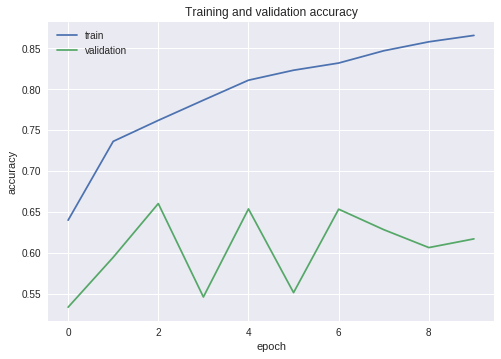

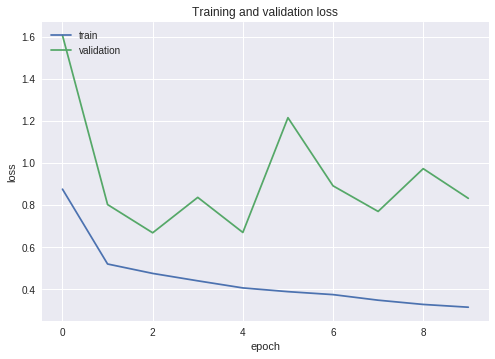

In [0]:
# Plot Training History.
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('accuracy', dpi=250)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# save image to disk
plt.savefig('loss', dpi=250)
plt.show()

In [0]:
keras.utils.plot_model(model, to_file='./graph_2.png')

In [0]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299,299),
    batch_size=64,
    class_mode='binary')

#finally evaluate this model on the test data
results = model.evaluate_generator(
    test_generator,
    steps=50)

print('Final test accuracy:', (results[1]*100.0))
 

Found 200 images belonging to 2 classes.
Final test accuracy: 69.26424050632912


In [0]:
#Saving the model
model.save('cardiomegaly_2.h5')